In [ ]:
from zipfile import ZipFile
import os

os.getcwd()

'/content'

In [ ]:
#change the directory
os.chdir('/content/drive/MyDrive/Colab Notebooks/Introduction to TensorFlow/Course 1 Labs')

#Set directory with horse pictures
train_horse_dir = os.path.join('./horses')

#Set directory with human pictures 
train_human_dir = os.path.join('./humans')

In [ ]:
#See what the filenames look like in the humans and horses directories

train_horse_names = os.listdir(train_horse_dir)
print(train_horse_names[:10])

train_human_names = os.listdir(train_human_dir)
print(train_human_names[:10])

['horse01-0.png', 'horse01-4.png', 'horse01-5.png', 'horse02-0.png', 'horse01-8.png', 'horse01-7.png', 'horse01-3.png', 'horse01-9.png', 'horse01-2.png', 'horse01-1.png']
['human01-00.png', 'human01-01.png', 'human01-02.png', 'human01-03.png', 'human01-04.png', 'human01-05.png', 'human01-06.png', 'human01-07.png', 'human01-09.png', 'human01-08.png']


In [ ]:
#You can also see the total number of horse and human images there are in their directories 
print('total training horse images: ', len(os.listdir(train_horse_dir)))
print('total training human images: ', len(os.listdir(train_human_dir)))

total training horse images:  500
total training human images:  527


Now take a look at a few pictures to get a better sense of what they look like

In [ ]:
#Configure the matplotlib parameters
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

#parameters for our graph; we'll output images in a 4x4 config
nrows = 4
ncols = 4

#index for iterating over images
pic_index = 0

Now display 8 horse and 8 human pics 

In [ ]:
#set up matplotlib fig and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows *4)

pic_index += 8

next_horse_pix = [os.path.join(train_horse_dir, fname)
                for fname in train_horse_names[pic_index - 8: pic_index]]

next_human_pix = [os.path.join(train_human_dir, fname)
                for fname in train_human_names[pic_index - 8: pic_index]]


for i, img_path in enumerate(next_horse_pix + next_human_pix):
  #set up subplot; subplot indicies start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('off')

  img = mpimg.imread(img_path)
  plt.imshow(img)


plt.show()

Building a small model from scratch:

Now you can define the model architecture that you will train. 

Step 1 is to import tensorflow

In [ ]:
import tensorflow as tf

Next add convolutional layers and flatten the final result to feed into the densely connected layers. 

*Note that because this is a two-class classification problem (binary-classification) you will end you network with a sigmoid activation

This makes the output value of your network a single scalar between 0 and 1

In [ ]:
model = tf.keras.models.Sequential([
    #Note the input shape is the desired size of the image (300 x 300) with 3 bytes color

    #This is the first convolution 
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(300, 300, 3)),
    tf.keras.layers.MaxPooling2D(2,2),
    #This is the second convolution
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    #This is the third convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    #This is the fourth convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    #This is the fith convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    #Flatten the results to feed into Densely connected layers
    tf.keras.layers.Flatten(),
    #512 neuron hidden layer 
    tf.keras.layers.Dense(512, activation='relu'),
    #Only 1 output neuron. It will contain the value from the sigmoid function 
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [ ]:
#review the network architecture and the output shapes with model.summary()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 298, 298, 16)      448       
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 149, 149, 16)     0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 147, 147, 32)      4640      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 73, 73, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 71, 71, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 35, 35, 64)       0

Next configure the specifications for model training 

You'll train this model with binary_crossentropy loss because it's a binary classification problem and the final activation is a sigmoid 

You'll use the rmsprop optimizer with a  learning rate of 0.001 (make sure to monitor classification accuracy to make sure the learning rate isn't too high)

*Note: RMSprop optimizaiton is preferable to stochastic gradient descent in this case because RMSprop automates learning rate tuning for us

In [ ]:
from tensorflow.keras.optimizers import RMSprop

model.compile(loss='binary_crossentropy',
              optimizer = RMSprop(learning_rate = 0.001),
              metrics = ['accuracy'])

Data Preprocessing:

The next step is to set up the data generators that will read pictures in the source folders, convert them to float32 tensors, and feed them (with their labels) to the model

You'll have one generator for the training images and one for the validation images. They will yield batches of images of size 300 x 300 and their labels (binary)

As you may already know, data that goes into neural networks should usually be normalized to make it more amenable to processing by the network. in this case, you will preprocess the images by normalizing the pixel values to be in the [0,1] range (originally, they were in the [0,255] range

In Keras, this can be done via the keras.preprocessing.image.ImageDataGenerator class using the rescale parameter. 

This ImageDataGenerator class allows you to instantiate generators of augmented image batches via .flow(data, labels) or .flow_from_directory(directory)

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#all images will be rescaled by 1./255.
train_datagen = ImageDataGenerator(rescale = 1/255)

#flow training images in batches of 128 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
    './', #this is the source directory for training images
    target_size = (300, 300), #all images will be resized to 300 x 300
    batch_size = 128,

    #since we use binary_crossentropy loss, we need binary labels 
    class_mode = 'binary')

Found 1027 images belonging to 2 classes.


Training: 

You can start training for 15 epochs

Note the values per epoch

The loss and accuracy are great indicators of the progress of training:
* loss measures the current model prediction against the known labels, calculating the result
* accuracy is the portion of correct guesses



In [ ]:
history = model.fit(
    train_generator, 
    steps_per_epoch = 8,
    epochs = 15,
    verbose = 1
)

Epoch 1/15
8/8 [==============================] - 170s 20s/step - loss: 0.7556 - accuracy: 0.5428
Epoch 2/15
8/8 [==============================] - 85s 10s/step - loss: 0.5433 - accuracy: 0.8164
Epoch 3/15
8/8 [==============================] - 76s 9s/step - loss: 0.2919 - accuracy: 0.8843
Epoch 4/15
8/8 [==============================] - 76s 9s/step - loss: 0.2755 - accuracy: 0.8921
Epoch 5/15
8/8 [==============================] - 75s 9s/step - loss: 0.3520 - accuracy: 0.8732
Epoch 6/15
8/8 [==============================] - 74s 9s/step - loss: 0.0825 - accuracy: 0.9700
Epoch 7/15
8/8 [==============================] - 72s 9s/step - loss: 0.1925 - accuracy: 0.9477
Epoch 8/15
8/8 [==============================] - 71s 9s/step - loss: 0.0681 - accuracy: 0.9722
Epoch 9/15
8/8 [==============================] - 71s 9s/step - loss: 0.2312 - accuracy: 0.9099
Epoch 10/15
8/8 [==============================] - 71s 9s/step - loss: 0.0497 - accuracy: 0.9800
Epoch 11/15
8/8 [===================

Model Prediciton:

Now take a look at actually running a prediciton using the model. This code will allow you to choose 1 or more files from you file system, upload them, and run them through the model, giving an indication of whether the object is a horse or a human

In [ ]:
import numpy as np
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():

  #prediciting images
  path = '/content/' + fn
  img = image.load_img(path, target_size = (300, 300))
  x = image.img_to_array(img)
  x /= 255
  x = np.expand_dims(x, axis = 0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size = 10)
  print(classes[0])

  if classes[0] > 0.5:
    print(fn + " is a human")
  else:
    print(fn + " is a horse")

Saving IMG_1783.jpg to IMG_1783 (1).jpg
[6.1411924e-07]
IMG_1783.jpg is a horse


Visualizing intermediate representations:

To get a feel for what kind of features your CNN has learned, one thing to do is to visualize how an input gets transformed as it goes through the model

You can pick a random image from the training set and then generate a figure where each row is the output of a layer and each image in the row is a specific filter in that output feature map

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in true_divide


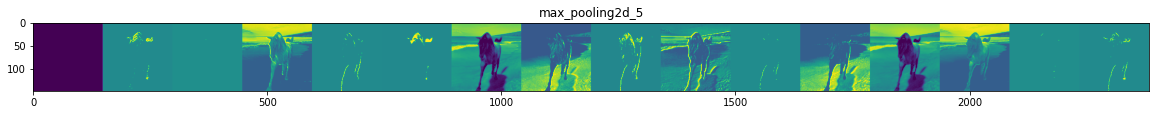

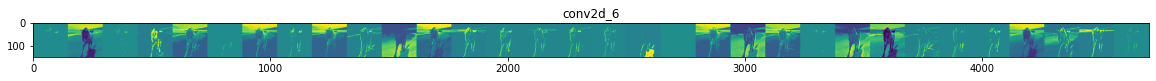

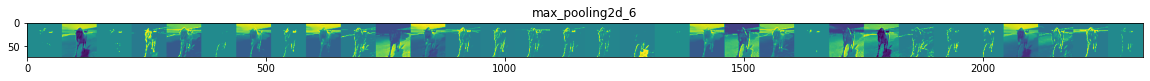

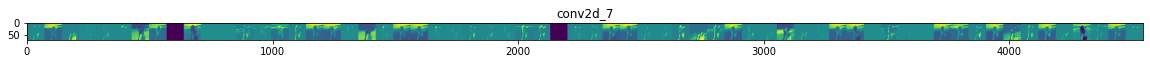

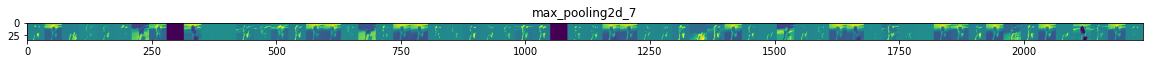

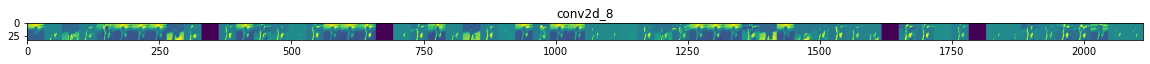

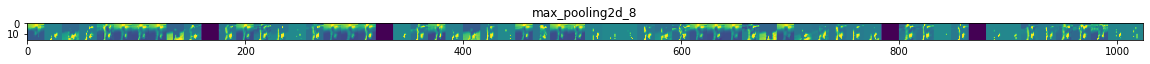

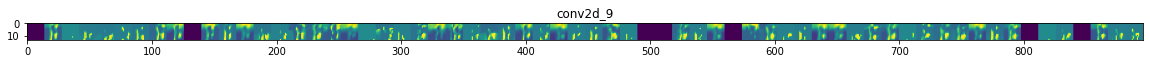

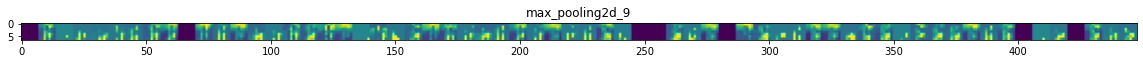

In [ ]:
import numpy as np
import random 
from tensorflow.keras.preprocessing.image import img_to_array, load_img

'''
define a new model that will take an image as input and will output the
intermediate representations for all the layers in the previous model
 '''

successive_outputs = [layer.output for layer in model.layers[1:]]
visualization_model = tf.keras.models.Model(inputs = model.input, outputs = successive_outputs)

#prepare a random input image from the training set
horse_img_files = [os.path.join(train_horse_dir, f) for f in train_horse_names]
human_img_files = [os.path.join(train_human_dir, f) for f in train_human_names]
img_path = random.choice(horse_img_files + human_img_files)

img = load_img(img_path, target_size = (300,300)) #this is a PIL image
x = img_to_array(img) #Numpy array with shape (300, 300, 3)
x = x.reshape((1,) + x.shape) #Numpy aray with shape (1, 300, 300, 3)

#scale by 1/255
x /= 255

#run the image through the network obtaining all intermediate representations for this image
successive_feature_maps = visualization_model.predict(x)

#these are the names of the layers, so you can have them as part of the plot 
layer_names = [layer.name for layer in model.layers[1:]]

#Display the representations 
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
  if len(feature_map.shape) == 4:
    
    #just do this for the convoluted/maxpool layers 
    n_features = feature_map.shape[-1] #number of features in feature map

    #The feature map has shape (1, size, size, n_features)
    size = feature_map.shape[1]

    #Tile the images in this matrix
    display_grid = np.zeros((size, size * n_features))
    
    for i in range(n_features):
      x = feature_map[0, :, :, i]
      x -= x.mean()
      x /= x.std()
      x *= 64
      x += 128
      x = np.clip(x, 0, 255).astype('uint8')

      #Tile each filter into this big horizontal grid 
      display_grid[:, i * size : (i + 1) * size] = x

    #display the grid
    scale = 20. / n_features 
    plt.figure(figsize = (scale * n_features, scale))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

In [ ]:
import os, signal

os.kill(os.getpid(), signal.SIGKILL)